In [1]:
import _readData # read my csv file to data frame
import _visualize # generate charts from my data frames

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint
from keras.models import load_model # type: ignore

In [3]:
# metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

In [4]:
df = _readData.reading('myData_MBB_priceHistory_20240321.csv')

r:\HOA18AO\stock price prediction\_readData.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date'] = pd.to_datetime(df['date'])


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3120 entries, 2024-03-21 to 2011-02-11
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3120 non-null   datetime64[ns]
 1   open     3120 non-null   float64       
 2   highest  3120 non-null   float64       
 3   lowest   3120 non-null   float64       
 4   close    3120 non-null   float64       
 5   volume   3120 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 170.6 KB


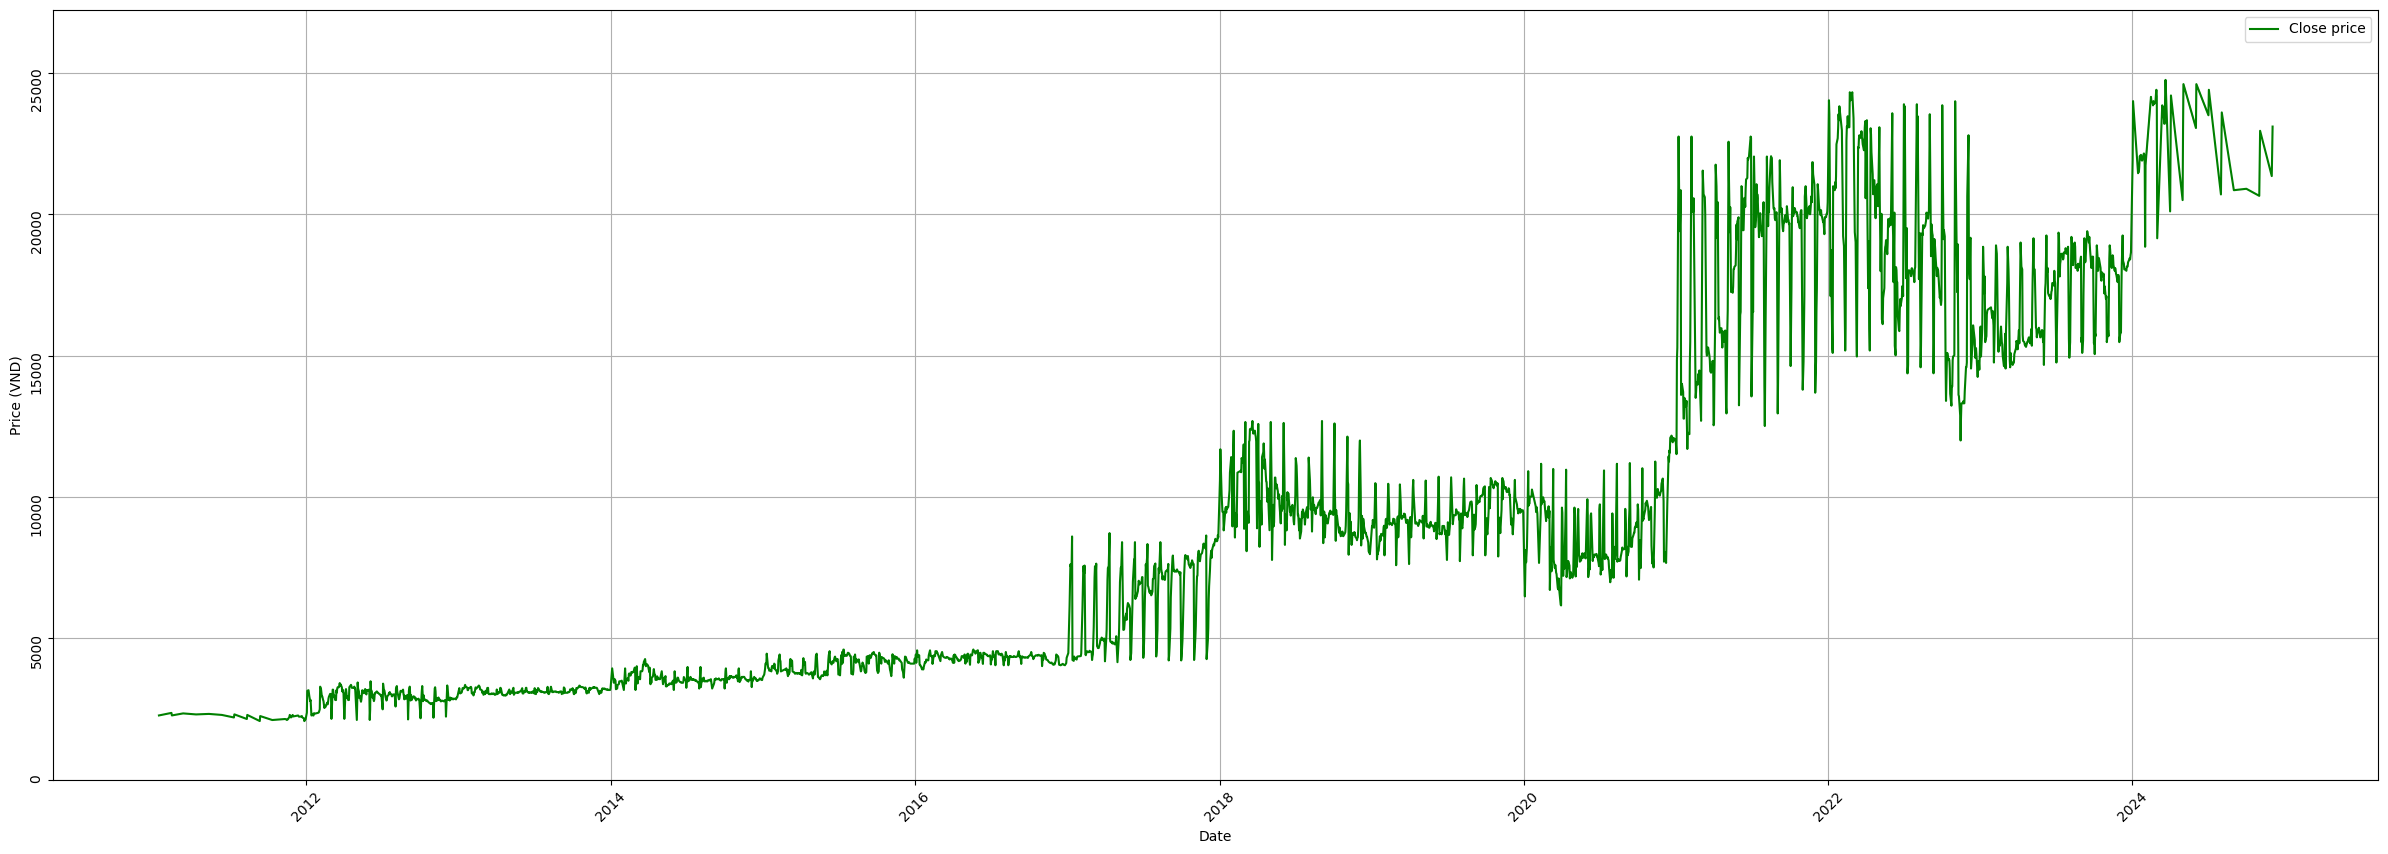

In [6]:
_visualize.drawChart2(df)

In [7]:
df = _readData.cleaning(df)
df

,open,highest,lowest,close,volume,tomorrow_close
date,,,,,,
2024-03-20,23200.0,24400.0,23100.0,24150.0,39357200,24750.0
2024-03-19,23200.0,23350.0,22950.0,23200.0,13605300,24150.0
2024-03-18,23750.0,23800.0,22400.0,23200.0,31782600,23200.0
2024-03-15,23450.0,23850.0,23150.0,23800.0,18886100,23200.0
2024-03-14,23950.0,23950.0,23400.0,23450.0,18358800,23800.0
...,...,...,...,...,...,...
2011-08-11,2171.0,2189.0,2117.0,2153.0,1105490,2081.0
2011-07-11,2315.0,2315.0,2207.0,2207.0,1221163,2153.0
2011-04-11,2369.0,2369.0,2315.0,2315.0,483860,2207.0


Scaling data

1. scale each column -> the scores are great but the actual predict is suck
2. scale all columns at once -> same result like last method
3. scale only the 'volume' -> same thing happened
4. scale all but the 'volume' -> eh
5. scale 'volume' and the others with different scaler ->it seems that your model is performing very well on the task for which it was trained

In [8]:
scaler_volume = MinMaxScaler().fit(df['volume'].values.reshape(-1, 1))
scaler_prices = MinMaxScaler().fit(df[['open', 'close', 'highest', 'lowest', 'tomorrow_close']].values.reshape(-1, 1))
scaler_prices, scaler_volume

(MinMaxScaler(), MinMaxScaler())

In [9]:
for col in df.columns:
    if col == 'volume':
        df[col] = pd.DataFrame(scaler_volume.transform(df[col].values.reshape(-1, 1)), index=df.index)
    elif col in ['open', 'highest', 'lowest', 'close', 'tomorrow_close']:
        df[col] = pd.DataFrame(scaler_prices.transform(df[col].values.reshape(-1, 1)), index=df.index)
        
df

,open,highest,lowest,close,volume,tomorrow_close
date,,,,,,
2024-03-20,0.915599,0.967538,0.911271,0.956717,0.531356,0.982687
2024-03-19,0.915599,0.922091,0.904778,0.915599,0.183188,0.956717
2024-03-18,0.939404,0.941569,0.880973,0.915599,0.428946,0.915599
2024-03-15,0.926420,0.943733,0.913435,0.941569,0.254585,0.915599
2024-03-14,0.948061,0.948061,0.924256,0.926420,0.247456,0.941569
...,...,...,...,...,...,...
2011-08-11,0.005410,0.006189,0.003073,0.004631,0.014190,0.001515
2011-07-11,0.011643,0.011643,0.006968,0.006968,0.015754,0.004631
2011-04-11,0.013980,0.013980,0.011643,0.011643,0.005786,0.006968


In [10]:
dfValues = df.values
# create sequences of data X and target Y for training
X = []
Y = []
# number of days to look back is 30 days
look_back = 30
for i in range(len(dfValues) - look_back):
    X.append(dfValues[i : i + look_back, [0, 1, 2, 3, 4]]) # sequence of 30 days
    Y.append(dfValues[i + look_back, [5]]) # close price of next day

X = np.array(X) # contain 'open','highest', 'lowest', 'close', 'volume' of 30 days (respectively) or the predictors
Y = np.array(Y) # contain 'close_tomorrow', which is the exact close price of the next day, which is the target that we want to predict

In [11]:
# lstm need differnct set of X, which is 3 dimensions
lstm_X = X
lstm_Y = Y

In [12]:
# turn X from 3 dimesions to 2 dimensions, for other machine learning models
tmp_X = [] # tmp_X is used for swap calue with X, keep up
for i in range(len(X)):
    tmp_X.append(X[i].reshape(-1))

X, tmp_X = tmp_X, X
X[0].size # == 150, because it 30 days multiple by 5 features (which features?)

150

In [13]:
# create train-test sets
splitPoint = int(0.7 * len(X)) # lenX == lenY, train set == 70%
X_train = X[:splitPoint]
X_test  = X[splitPoint:]
Y_train = Y[:splitPoint]
Y_test  = Y[splitPoint:]

# LSTM (Long Short-term Memories)

In [14]:
# prepare train-test set for lstm model
# splitPoint is existed, make sure train set is about 70% of the whole dataset
lstm_X_train = lstm_X[:splitPoint]
lstm_X_test  = lstm_X[splitPoint:]
lstm_Y_train = lstm_Y[:splitPoint]
lstm_Y_test  = lstm_Y[splitPoint:]

In [15]:
# import models
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
#from keras.layers import RNN

In [16]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(30, 5)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

In [17]:
# using lstm_X/lstm_Y
save_model = 'savedModel_LSTM.h5'
best_choice = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(lstm_X_train, lstm_Y_train, epochs=10, batch_size=32, callbacks=[best_choice])

Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 0.0130
Epoch 1: loss improved from inf to 0.01303, saving model to savedModel_LSTM.h5
68/68 [==============================] - 4s 12ms/step - loss: 0.0130
Epoch 2/10
64/68 [===========================>..] - ETA: 0s - loss: 3.6993e-04
Epoch 2: loss improved from 0.01303 to 0.00037, saving model to savedModel_LSTM.h5
68/68 [==============================] - 1s 11ms/step - loss: 3.6586e-04
Epoch 3/10
64/68 [===========================>..] - ETA: 0s - loss: 2.9855e-04
Epoch 3: loss improved from 0.00037 to 0.00030, saving model to savedModel_LSTM.h5
68/68 [==============================] - 1s 10ms/step - loss: 2.9588e-04
Epoch 4/10
68/68 [==============================] - ETA: 0s - loss: 2.4136e-04
Epoch 4: loss improved from 0.00030 to 0.00024, saving model to savedModel_LSTM.h5
68/68 [==============================] - 1s 13ms/step - loss: 2.4136e-04
Epoch 5/10
65/68 [===========================>..] - ETA: 0s - loss: 2.13

In [18]:
loss = model.evaluate(lstm_X_test, lstm_Y_test)
lstm_Y_pred = model.predict(lstm_X_test)
r2 = r2_score(lstm_Y_test, lstm_Y_pred)
mae = mean_absolute_error(lstm_Y_test, lstm_Y_pred)
#loss # mse

29/29 [==============================] - 1s 4ms/step


In [19]:
mean_absolute_error(lstm_Y_test, lstm_Y_pred)

0.004679793457489329

In [20]:
lstm_X_test.shape

(927, 30, 5)

In [21]:
result_lstm = {
    'MAE' : mean_absolute_error(lstm_Y_test, lstm_Y_pred),
    'MSE' : mean_squared_error(lstm_Y_pred, lstm_Y_test),
    'RMSE': root_mean_squared_error(lstm_Y_pred, lstm_Y_test),
    'R2'  : r2_score(lstm_Y_test, lstm_Y_pred)
}

In [46]:
print(
    'LSTM',
    '\nMAE    : ', "{:.6f}".format(result_lstm['MAE']),
    '\nMSE    : ', "{:.6f}".format(result_lstm['MSE']),
    '\nRMSE   : ', "{:.6f}".format(result_lstm['RMSE']),
    '\nR2     : ', "{:.6f}".format(result_lstm['R2'])
)

LSTM 
MAE    :  0.004680 
MSE    :  0.000028 
RMSE   :  0.005257 
R2     :  0.931880


```
consider using real value (pre-scaled) to evaluate the models

# Random Forest

In [22]:
import joblib # for saving models weights
from sklearn.ensemble import RandomForestRegressor

In [23]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [24]:
rf_model.fit(X,Y) # using X/Y
rf_model

c:\Users\tranh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [25]:
joblib.dump(rf_model, 'savedModel_RandomForest.h5')

['savedModel_RandomForest.h5']

In [26]:
rf_Y_pred = rf_model.predict(X_test)
#rf_Y_pred

r2 score is not commonly used for Random forest model, because R2 is calculated based on the total variance in the data and the variance that is explained by the model. While it's straightforward for simple linear models, Random Forests are more complex and nonlinear, making the interpretation of 𝑅2 less meaningful. Random Forests tend to capture more complex patterns in the data beyond linear relationships.

In [47]:
result_rf = {
    'MAE' : mean_absolute_error(rf_Y_pred, Y_test),
    'MSE' : mean_squared_error(rf_Y_pred, Y_test),
    'RMSE': root_mean_squared_error(rf_Y_pred, Y_test)
}

In [50]:
print(
    'Random Forest',
    '\nMAE  : ', '{:.8f}'.format(result_rf['MAE']),
    '\nMSE  : ', '{:.8f}'.format(result_rf['MSE']),
    '\nRMSE : ', '{:.8f}'.format(result_rf['RMSE'])
)

Random Forest 
MAE  :  0.00003894 
MSE  :  0.00000001 
RMSE :  0.00011079


```
consider using real value (pre-scaled) to evaluate the models

# XGBoots

In [28]:
from xgboost import XGBRegressor

In [29]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Specify the objective function for regression task (minimize squared error)
    n_estimators=100,               # Number of boosting rounds (trees) to build
    max_depth=5,                    # Maximum depth of each tree
    learning_rate=0.1,              # Learning rate (shrinkage) of each tree's contribution
    gamma=0,                        # Minimum loss reduction required to make a further partition on a leaf node
    subsample=0.8,                  # Subsample ratio of the training instances (prevent overfitting)
    colsample_bytree=0.8,           # Subsample ratio of columns when constructing each tree
    random_state=42                 # Random seed for reproducibility
)

In [30]:
xgb_model.fit(X_train, Y_train) # using X/Y

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

XGBoost is a highly flexible and nonlinear model that can capture complex relationships in the data. Like Random Forests, the 𝑅2 score may not effectively capture the performance of such models due to its assumption of linearity and simplicity.

In [53]:
xgb_Y_pred = xgb_model.predict(X_test)

In [51]:
result_xgb = {
    'MAE' : mean_absolute_error(xgb_Y_pred.reshape(-1, 1), Y_test),
    'MSE' : mean_squared_error(xgb_Y_pred.reshape(-1, 1), Y_test),
    'RMSE': root_mean_squared_error(xgb_Y_pred.reshape(-1, 1), Y_test)
}

In [52]:
print(
    'XGBOOST',
    '\nMAE  : ', '{:.8f}'.format(result_xgb['MAE']),
    '\nMSE  : ', '{:.8f}'.format(result_xgb['MSE']),
    '\nRMSE : ', '{:.8f}'.format(result_xgb['RMSE'])
)

XGBOOST 
MAE  :  0.03022176 
MSE  :  0.00126745 
RMSE :  0.03560130


```
consider using real value (pre-scaled) to evaluate the models

# Prophet

```
why not split train/test set?
```
- Splitting time series data randomly into train and test sets can break this temporal continuity and violate the inherent dependencies and patterns present in the data.
- In time series forecasting, it's crucial to maintain the chronological order of data to accurately capture trends, seasonality, and other time-related patterns.
```
Evaluation Metrics and Validation
```
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)


In [32]:
from prophet import Prophet

c:\Users\tranh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [33]:
# create a new df for prophet
pro_df = pd.DataFrame(
    {
        'ds' : df.index, # ds == timestamp
        'y' : df['tomorrow_close'], # target variable
        'open' : df['open'],
        'high' : df['highest'],
        'low' : df['lowest'],
        'close' : df['close'],
        'volume' : df['volume'] 
    }
)

In [34]:
pro_df.columns

Index(['ds', 'y', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [35]:
pro_model = Prophet()
pro_model.add_regressor('open')
pro_model.add_regressor('high')
pro_model.add_regressor('low')
pro_model.add_regressor('close')
pro_model.add_regressor('volume')


In [36]:
pro_model.fit(pro_df) # auto know 'y' as target column and 'ds' as timestamp

00:28:45 - cmdstanpy - INFO - Chain [1] start processing
00:28:46 - cmdstanpy - INFO - Chain [1] done processing


function to check how effective the model is
using mae, mse, rmse

In [37]:
# look_back = 30
# image a list of df, each has 30 row as 30 past day
futures_df = [] # a list of df
for i in range(len(pro_df.values) - look_back):
    # i from 0 -> ...
    last_30_days = pro_df[i:i+30] # 30 rows as 30 days
    futures_df.append(
        pd.DataFrame(
            {
                'ds' : [pro_df.index[i]]*30, # next day
                'open' : last_30_days['open'].tolist(),
                'high' : last_30_days['high'].tolist(),
                'low'  : last_30_days['low'].tolist(),
                'close' : last_30_days['close'].tolist(),
                'volume' : last_30_days['volume'].tolist()
            }
        )
    )

In [38]:
len(futures_df), # 3089 30-days dataframes, these contains predicted values
len(Y), # 3089 too, these are actual values
Y.shape # 3089, 1

(3089, 1)

In [39]:
forecasts_df = [] #  a list of dataframe conatains (pro_model.predict(future[i]))
pro_Y_pred = []
for future in futures_df:
    forecasts_df.append(pro_model.predict(future))

# each forecast is a df with 30 rows, the answer we need (yhat) is on the first row(last day, or 30th day in that 30 day)
for forecast in forecasts_df:
    pro_Y_pred.append(forecast['yhat'].iloc[0])
    
# runtime 3m

In [54]:
result_pro = { # prophet
    'MAE' : mean_absolute_error(y_pred=pro_Y_pred, y_true=Y),
    'MSE' : mean_squared_error(y_pred=pro_Y_pred, y_true=Y),
    'RMSE': root_mean_squared_error(y_pred=pro_Y_pred, y_true=Y)
}

In [55]:
print(
    'Prophet',
    '\nMAE  : ', '{:.8f}'.format(result_pro['MAE']),
    '\nMSE  : ', '{:.8f}'.format(result_pro['MSE']),
    '\nRMSE : ', '{:.8f}'.format(result_pro['RMSE'])
)

Prophet 
MAE  :  0.03196312 
MSE  :  0.00279178 
RMSE :  0.05283726


# ARIMA (Auto Regressive Integrated Moving Average)

check if the series (dataset) is stationary or not


ARIMA models, in their standard form, are not ideal for directly handling multiple features in a time series dataset. Here's why:
```
ARIMA assumes a single time series: It's designed to forecast a single dependent variable based on its own past values (autoregression), differencing for stationarity, and past forecast errors (moving average).
